## Introduction

For the final assignment in Intro to Deep Learning, I'll be focusing on developing a model that is able to determine whether an image of a chest x-ray has pneumonia or not. This could be extremely useful in the medical field, as if a doctor could just upload an image of an x-ray and immediately know whether the patient has pneumonia or not, they would likely save time. This could also allow patients to upload their own x-ray if possible. Of course, this completely relies on the data being constructed using labels set by doctors at first, so based on this data, let's see if it's possible. The dataset can be found here: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia.

## Data Import and EDA

In [1]:
# loading in most necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [2]:
# loading in data
training_dir="../input/chest-xray-pneumonia/chest_xray/train/"
training_generator=ImageDataGenerator(rescale=1/255,featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 45,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.5, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)
train_generator=training_generator.flow_from_directory(training_dir,target_size=(200,200),batch_size=4,class_mode='binary')

Found 5216 images belonging to 2 classes.


In our training set, there are 5216 images that either have Pneumonia or are healthy. To prepare the data further, I added some data augmentation in the training set. The steps that are included are rotating some images by 45 degrees, zoom some of the images up to 50%, shift some of the images horizontally 10%, and shift some of the images vertically by 10%. I think this will provide a more "random" dataset than what we were provided.

In [3]:
val_dir="../input/chest-xray-pneumonia/chest_xray/val/"
validation_generator=ImageDataGenerator(rescale=1/255)
val_generator=validation_generator.flow_from_directory(val_dir,target_size=(200,200),batch_size=4,class_mode='binary')

Found 16 images belonging to 2 classes.


In [4]:
test_dir="../input/chest-xray-pneumonia/chest_xray/test/"
test_generator=ImageDataGenerator(rescale=1/255)
test_generator=test_generator.flow_from_directory(test_dir,target_size=(200,200),batch_size=16,class_mode='binary')

Found 624 images belonging to 2 classes.


For our validation and test sets, there are only 16 and 624 images respectively. This could cause issues with the models later on, though it may be unlikely. Let's also take a look at an image of lungs that have pneumonia and some that don't have pneumonia via google:

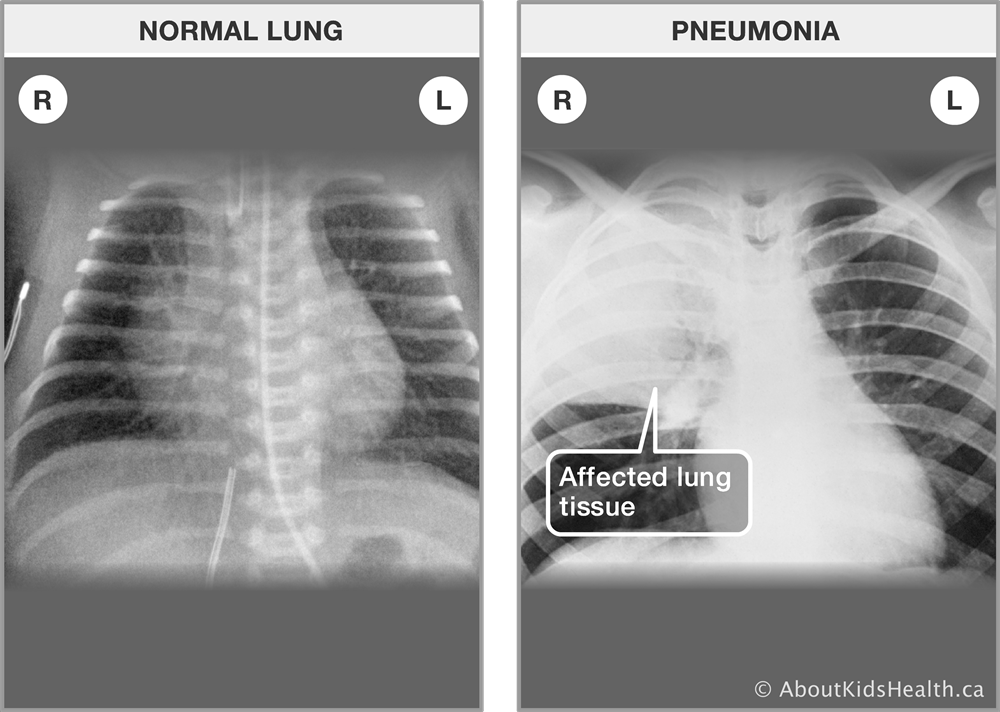

We can see from the above image that lungs with Pneumonia will likely have more coloration in the lungs compared to those that are healthy. This should be represented in our data set as well.

## Model Creation and Tuning

Now that we have our datasets, we'll start creating models. The main models that I want to explore are CNN models with different architecture. First, I'll start with a model that has a convolution layer, max pooling layer, then repeat that step with a dropout layer, then finally one last dropout layer before activating. 

The next model will have an extra set of convolution and max pooling layers, to see if there's an increase in accuracy. Finally, I will tune the learning rate on whichever model performs better to determine if there is an ideal learning rate. This will run for a total of 5 epochs each time.

In [5]:
model1 =tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),input_shape=(200,200,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])

2022-12-05 01:42:32.742100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 01:42:32.743589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 01:42:33.100594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 01:42:33.101529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 01:42:33.102424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [6]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['acc'])

In [7]:
history1 = model1.fit(train_generator,validation_data = val_generator,epochs = 5,verbose = 1)

2022-12-05 01:42:38.453043: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-12-05 01:42:41.116637: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1304/1304 [==============================] - 163s 115ms/step - loss: 0.5952 - acc: 0.7554 - val_loss: 0.7016 - val_acc: 0.5625
Epoch 2/5
1304/1304 [==============================] - 114s 87ms/step - loss: 0.4530 - acc: 0.7780 - val_loss: 1.0474 - val_acc: 0.5000
Epoch 3/5
1304/1304 [==============================] - 114s 88ms/step - loss: 0.4400 - acc: 0.7889 - val_loss: 0.5066 - val_acc: 0.8750
Epoch 4/5
1304/1304 [==============================] - 115s 88ms/step - loss: 0.4050 - acc: 0.8127 - val_loss: 0.6997 - val_acc: 0.7500
Epoch 5/5
1304/1304 [==============================] - 114s 88ms/step - loss: 0.3795 - acc: 0.8315 - val_loss: 0.7460 - val_acc: 0.6875


In [8]:
model2 =tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),input_shape=(200,200,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])

In [9]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['acc'])

In [10]:
history2 = model2.fit(train_generator ,validation_data = val_generator,epochs = 5,verbose = 1)

Epoch 1/5
1304/1304 [==============================] - 114s 86ms/step - loss: 0.5402 - acc: 0.7464 - val_loss: 1.1212 - val_acc: 0.5625
Epoch 2/5
1304/1304 [==============================] - 113s 86ms/step - loss: 0.4629 - acc: 0.7770 - val_loss: 0.5553 - val_acc: 0.8750
Epoch 3/5
1304/1304 [==============================] - 113s 87ms/step - loss: 0.4087 - acc: 0.8154 - val_loss: 0.5934 - val_acc: 0.8125
Epoch 4/5
1304/1304 [==============================] - 113s 86ms/step - loss: 0.3710 - acc: 0.8367 - val_loss: 0.9543 - val_acc: 0.6875
Epoch 5/5
1304/1304 [==============================] - 113s 86ms/step - loss: 0.3633 - acc: 0.8441 - val_loss: 0.7488 - val_acc: 0.7500


Now, let's plot both models training and validation accuracy over the number of epochs to see which one looks better:

<Figure size 432x288 with 0 Axes>

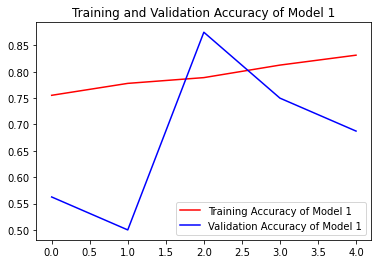

<Figure size 432x288 with 0 Axes>

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy of Model 1')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy of Model 1')
plt.title('Training and Validation Accuracy of Model 1')
plt.legend(loc=0)
plt.figure()

<Figure size 432x288 with 0 Axes>

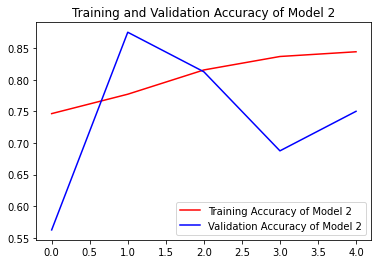

<Figure size 432x288 with 0 Axes>

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy of Model 2')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy of Model 2')
plt.title('Training and Validation Accuracy of Model 2')
plt.legend(loc=0)
plt.figure()

Since the second model's architecture performed better based on the training accuracy, let's do a bit of hyper-parameter tuning on the learning rate. It's not surprising that this model's architecture performed at a higher level, as the further convolutions and pooling introduced more nuance to the model. We'll try three different learning rates to see if there's one particular learning rate that is best. I know ideally we'd want to do a GridSearchCV to determine if there is a specific learning rate, loss function, or architecture that works best, but due to computational strength, this analysis will be restricted to these three learning rates.

In [13]:
hyperModel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),input_shape=(200,200,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])

In [14]:
lrs = [0.001,0.005,0.01]
for i in lrs:
    hyperModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),loss='binary_crossentropy',metrics=['acc'])
    historyHyper = hyperModel.fit(train_generator ,validation_data = val_generator,epochs = 5,verbose = 1)
    print('Model 2 with LR of: ' + str(i))
    print(historyHyper.history['acc'])
    print(historyHyper.history['val_acc'])

Epoch 1/5
1304/1304 [==============================] - 114s 87ms/step - loss: 0.5381 - acc: 0.7506 - val_loss: 0.7775 - val_acc: 0.7500
Epoch 2/5
1304/1304 [==============================] - 115s 88ms/step - loss: 0.4696 - acc: 0.7778 - val_loss: 0.6421 - val_acc: 0.8125
Epoch 3/5
1304/1304 [==============================] - 114s 87ms/step - loss: 0.4386 - acc: 0.8014 - val_loss: 0.5668 - val_acc: 0.8125
Epoch 4/5
1304/1304 [==============================] - 114s 87ms/step - loss: 0.3767 - acc: 0.8292 - val_loss: 0.6064 - val_acc: 0.7500
Epoch 5/5
1304/1304 [==============================] - 113s 87ms/step - loss: 0.3352 - acc: 0.8610 - val_loss: 0.8344 - val_acc: 0.6250
Model 2 with LR of: 0.001
[0.7505751252174377, 0.7777990698814392, 0.8013803958892822, 0.8291794657707214, 0.8610045909881592]
[0.75, 0.8125, 0.8125, 0.75, 0.625]
Epoch 1/5
1304/1304 [==============================] - 114s 87ms/step - loss: 0.5922 - acc: 0.7448 - val_loss: 0.8251 - val_acc: 0.5000
Epoch 2/5
1304/1304 [

Based on the above output, it looks like the best learning rate is 0.001. With this learning rate, the model was able to achieve a maximum accuracy of 0.86. This makes sense, as the model is learning at a "slower" rate, and achieving the more optimal weights in the model at the end. So, utilizing this model, we'll predict on our training set below in the Results section.

## Results

From our tuning and model building, the model that has been chosen for prediction will be the Model 2, with a learning rate of 0.001. This model can be seen below:

In [15]:
print("Loss of the model is - " , model2.evaluate(test_generator)[0]*100 , "%")
print("Accuracy of the model is - " , model2.evaluate(test_generator)[1]*100 , "%")

39/39 [==============================] - 11s 281ms/step - loss: 0.5165 - acc: 0.7468
Loss of the model is -  51.64765119552612 %
39/39 [==============================] - 7s 170ms/step - loss: 0.5165 - acc: 0.7468
Accuracy of the model is -  74.67948794364929 %


So, using the CNN with the architecture of Model 2 from above, the accuracy is 74.7% on the testing set. While not ideal, this does illustrate the possibilities that are available when it comes to image recognition. If given enough time, I imagine that a model could be created that has as close to, if not a higher accuracy than some medical professionals, given that the data the model has been given is curated correctly.

## Conclusion

Through CNNs and neural networks, the world is going to have rethink how many seemingly specialized tasks can be automated. Even this CNN model was able to have a 90.54% accuracy after a bit of fine tuning and a small validation set. If a model has enough data and enough computational power is put into it, models that we create can be utilized across any industry, including the healthcare field. One important thing to remember is that there is inherent bias in our model based on the data we trained it on. So, while I'm confident in the future that there could be models that are able to predict cancer, pneumonia, or other medical diseases, for now I'd prefer the personal touch of my primary care provider. Going forward, some things that should be added to this analysis would be an increase in validation data, either from curating more data or augmenting the existing validation data. Also, a more thorough tuning of the hyper-parameters may lead to more accurate models. Finally, a change in model architecture could reveal a more accurate way to predict the pneumonia.